## In this notebook, we'll apply the PyTorch Workflow we covered in notebooks 01 and 02 to a computer vision problem, using our own dataset of pizza, steak and sushi images.

In [ ]:
# 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting?
# - Increase dataset size - provide more images
# - Data Augmentation - transform existing data (rotate, flip, crop), making it more diverse
# - Increase model complexity - add layers (or neurons)
# - Increase training duration - add epochs
# - Try different optimizers - Adam, SGD, etc.

# check for GPU
!nvidia-smi

Mon Jun 16 23:18:38 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import torch
from torch import nn
print (torch.__version__)  # we need version >= 1.10.0

device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.6.0+cu124


'cuda'

In [ ]:
# Increase dataset size
import requests
import zipfile
from pathlib import Path

# Setup path to datafile
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download and prepare it
if image_path.is_dir():
  print(f"{image_path} directory exists")
else:
  print(f"{image_path} directory not found, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download images
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
  print("Downloading pizza, steak, sushi 20% data...")
  f.write(request.content)

# Unzip data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:  # note capital F in .ZipFile
  print("Unzipping pizza, steak, sushi 20% data...")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi_20_percent directory not found, creating one...
Unzipping pizza, steak, sushi 20% data...


In [ ]:
# see how many images we have
import os

def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi_20_percent'
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/train'
There are 0 directories and 146 images in 'data/pizza_steak_sushi_20_percent/train/steak'
There are 0 directories and 150 images in 'data/pizza_steak_sushi_20_percent/train/sushi'
There are 0 directories and 154 images in 'data/pizza_steak_sushi_20_percent/train/pizza'
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/test'
There are 0 directories and 58 images in 'data/pizza_steak_sushi_20_percent/test/steak'
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/sushi'
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/pizza'


In [ ]:
!ls data/pizza_steak_sushi_20_percent/train
!ls data/pizza_steak_sushi_20_percent/test

pizza  steak  sushi
pizza  steak  sushi


In [ ]:
# Create train and test paths
train_data_20_path = image_path / "train"
test_data_20_path = image_path / "test"

train_data_20_path, test_data_20_path

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [ ]:
# Turn 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([  # use this for test datasets
    # Resize the images to 224x224
    transforms.Resize((224,224)),#64,64)),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()  # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

data_20_transform = transforms.Compose([
    transforms.Resize((224,224)),#64,64)),
    # Flip images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),  # p = probability of flip, 0.5 = 50% chance
    transforms.ToTensor()
])

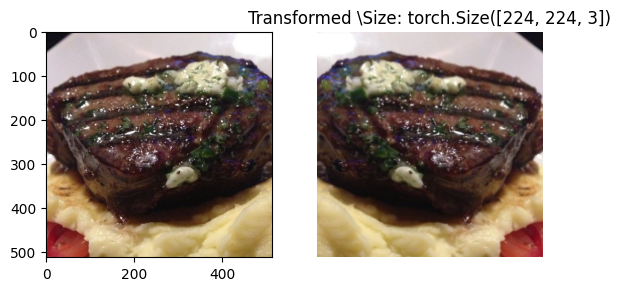

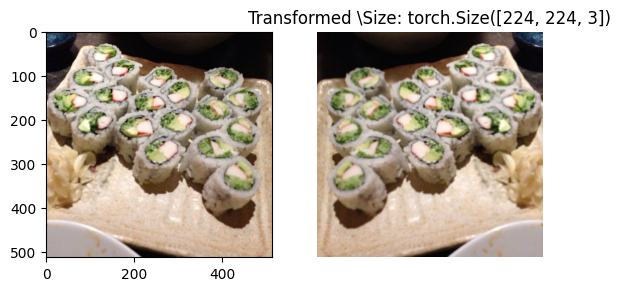

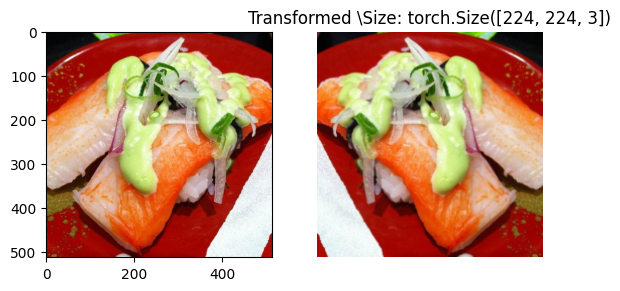

In [ ]:
# Write a function to see transforms on various images
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image

image_path_list = list(image_path.glob("*/*/*.jpg"))

"""Plots a series of random images from image_paths.

Will open n image paths from image_paths, transform them
with transform and plot them side by side.

Args:
    image_paths (list): List of target image paths.
    transform (PyTorch Transforms): Transforms to apply to images.
    n (int, optional): Number of images to plot. Defaults to 3.
    seed (int, optional): Random seed for the random generator. Defaults to 14.
"""
def plot_transformed_images(image_paths, transform, n=3, seed=14):
  random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1,2)
      ax[0].imshow(f)
      ax[1].set_title(f"Orginal \nSize: {f.size}")

      # Transform and plot image
      # Note: permute() will change shape of image to suit matplotlib
      # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
      transformed_image = transform(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \Size: {transformed_image.shape}")
      ax[1].axis("off")

plot_transformed_images(image_paths=image_path_list,
                        transform=data_20_transform,
                        n=3)

In [ ]:
# Create datasets
from torchvision import datasets
train_data_20 = datasets.ImageFolder(root=train_data_20_path,      # train/ folder images
                                     transform=data_20_transform,  # transformed data
                                     target_transform=None)        # no label transforms needed
test_data_20 = datasets.ImageFolder(root=test_data_20_path,
                                    transform=data_20_transform)
train_data_20, test_data_20

(Dataset ImageFolder
     Number of datapoints: 450
     Root location: data/pizza_steak_sushi_20_percent/train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 150
     Root location: data/pizza_steak_sushi_20_percent/test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [ ]:
# Inspect the datasets
class_names = train_data_20.classes
class_dict = train_data_20.class_to_idx
class_names, class_dict

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [ ]:
# Turn train and test datasets into DataLoaders (making them iterable)
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data_20,
                              batch_size=1,   # of samples per batch
                              num_workers=1,  # of subprocesses to use for data loading
                              shuffle=True)   # shuffle the data
test_dataloader = DataLoader(dataset=test_data_20,
                             batch_size=1,
                             num_workers=1,
                             shuffle=False)   # don't usually need to shuffle test data
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7e6c45a75750>,
 <torch.utils.data.dataloader.DataLoader at 0x7e6d418bfb50>)

In [ ]:
# Batch size is currently 1
img, label = next(iter(train_dataloader))
img.shape, label.shape

(torch.Size([1, 3, 224, 224]), torch.Size([1]))

In [ ]:
# TinyVGG class
class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG from:
  https://poloclub.github.io/cnn-explainer/
  """
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,  # size of square going over image
                  stride=1,       # default
                  padding=1),     # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)  # default stride = kernel_size
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*56*56, #*16*16,  # in_features shape from each layer compressing, changing shape of input data
                  out_features=output_shape)
    )

  def forward(self, x: torch.Tensor):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x

torch.manual_seed(42)
model_20 = TinyVGG(input_shape=3,
                   hidden_units=10,
                   output_shape=len(train_data_20.classes)).to(device)
model_20

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=31360, out_features=3, bias=True)
  )
)

In [ ]:
# train_step function
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):

  # Put model in train mode
  model.train()

  # Set up loss and accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate and accumulate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumulate accuracy metrics across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item() / len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  return train_loss, train_acc

In [ ]:
# test_step function
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
  # Put model in eval mode
  model.eval();

  # Set up test loss and accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through dataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send to target device
      X, y = X.to(device), y.to(device)
      # 1. Forward pass
      test_pred = model(X)  # in logits, or test_pred_logits
      # 2. Calculate and accumulate loss
      test_loss += loss_fn(test_pred, y).item()
      # Calculate and accumulate accuracy
      test_pred_labels = test_pred.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))

  # Adjust metrics for average loss, acc per batch
  test_loss /= len(dataloader)
  test_acc /= len(dataloader)
  return test_loss, test_acc

In [ ]:
# Create a train function
from tqdm.auto import tqdm

# Take in parms required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

  # 2. Create empty dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # 3. Loop through train and test steps for number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)

    # 4. Print out what's happening
    print(f"Epoch: {epoch+1} | Train loss: {train_loss:.4f} | Train accuracy: {train_acc:.4f} | "
          f"Test loss: {test_loss:.4f} | Test accuracy: {test_acc:.4f}")

    # 5. Update results dictionary
    # Ensure all data moved to CPU as float for storage
    results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
    results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
    results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
    results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

  # Return filled results after all epochs
  return results

In [ ]:
# Train and test the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# SGD got up to .7333 accuracy with 22 epochs and 15 hidden_units
# SGD got up to .8400 accuracy with 25 epochs and 20 hidden_units.  --still doesn't help with single-slice or side-view pizza custom images, maybe because test loss
NUM_EPOCHS = 15 #25 #22 #20 #10                                     --stops decreasing while train loss keeps decreasing. Probably still need way more train/test data.

# Recreate an instance of TinyVGG
model_20 = TinyVGG(input_shape=3,    # of RGB color channels
                   hidden_units=20,  #15,#10,
                   output_shape=len(train_data_20.classes)).to(device)

# Set up loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(params=model_20.parameters(), lr=0.001)
optimizer = torch.optim.SGD(params=model_20.parameters(), lr=0.001)  # SGD is working better than Adam

# Start timer
from timeit import default_timer as timer
start_time = timer()

# Train model_20
model_20_results = train(model=model_20,
                         train_dataloader=train_dataloader,
                         test_dataloader=test_dataloader,
                         optimizer=optimizer,
                         loss_fn=loss_fn,
                         epochs=NUM_EPOCHS)

# End and print time
end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 1.1038 | Train accuracy: 0.3156 | Test loss: 1.0939 | Test accuracy: 0.3867
Epoch: 2 | Train loss: 1.0964 | Train accuracy: 0.3756 | Test loss: 1.0911 | Test accuracy: 0.3933
Epoch: 3 | Train loss: 1.0887 | Train accuracy: 0.4067 | Test loss: 1.0774 | Test accuracy: 0.4267
Epoch: 4 | Train loss: 1.0637 | Train accuracy: 0.5044 | Test loss: 1.0192 | Test accuracy: 0.5200
Epoch: 5 | Train loss: 0.9890 | Train accuracy: 0.5511 | Test loss: 0.9084 | Test accuracy: 0.5867
Epoch: 6 | Train loss: 0.9194 | Train accuracy: 0.5911 | Test loss: 0.8900 | Test accuracy: 0.5600
Epoch: 7 | Train loss: 0.8888 | Train accuracy: 0.6156 | Test loss: 0.8930 | Test accuracy: 0.5533
Epoch: 8 | Train loss: 0.8771 | Train accuracy: 0.5689 | Test loss: 0.8772 | Test accuracy: 0.6000
Epoch: 9 | Train loss: 0.8575 | Train accuracy: 0.6156 | Test loss: 0.8706 | Test accuracy: 0.6000
Epoch: 10 | Train loss: 0.8273 | Train accuracy: 0.6467 | Test loss: 0.8875 | Test accuracy: 0.5067
Epoch: 11

In [ ]:
# Check model_20_results keys
model_20_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

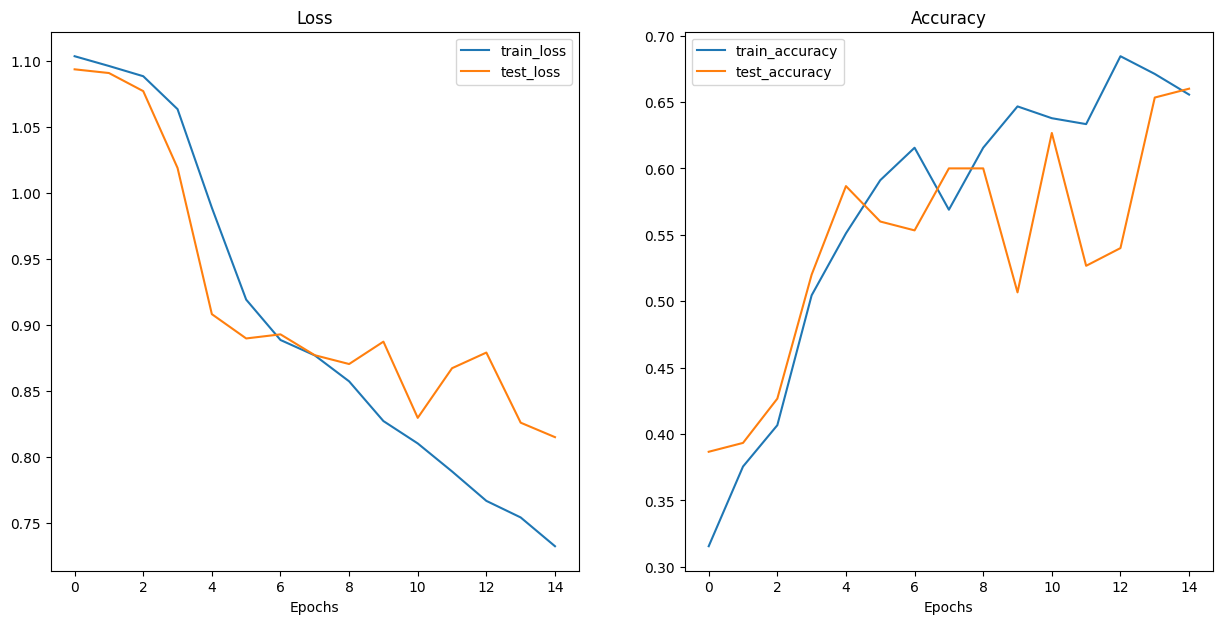

In [ ]:
# Extract each of the keys above and plot them
from typing import Dict, List

def plot_loss_curves(results: Dict[str, List[float]]):
  """Plots training curves of a results dictionary.

  Args:
      results (dict): dictionary containing list of values, e.g.
          {"train_loss": [...],
           "train_acc": [...],
           "test_loss": [...],
           "test_acc": [...]}
  """
  # Get the loss values of the results dictionary (training and test)
  loss = results['train_loss']
  test_loss = results['test_loss']

  # Get the accuracy values of the results dictionary (training and test)
  accuracy = results['train_acc']
  test_accuracy = results['test_acc']

  # Figure out how many epochs there were
  epochs = range(len(results['train_loss']))

  # Set up a plot
  plt.figure(figsize=(15, 7))

  # Plot loss
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label='train_loss')
  plt.plot(epochs, test_loss, label='test_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label='train_accuracy')
  plt.plot(epochs, test_accuracy, label='test_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

plot_loss_curves(model_20_results)

In [ ]:
# Try augmented transform
data_20_augmented_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()])

# It is generally necessary to apply the same transformations to the test data as were applied to the training set

# Turn images into datasets
train_data_20_augmented = datasets.ImageFolder(train_data_20_path,
                                               transform=data_20_augmented_transform,
                                               target_transform=None)
test_data_20_augmented = datasets.ImageFolder(test_data_20_path,
                                              transform=data_20_augmented_transform)

train_data_20_augmented, test_data_20_augmented

(Dataset ImageFolder
     Number of datapoints: 450
     Root location: data/pizza_steak_sushi_20_percent/train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 150
     Root location: data/pizza_steak_sushi_20_percent/test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ))

In [ ]:
# Turn augmented train and test datasets into DataLoaders (making them iterable)
train_dataloader_aug = DataLoader(dataset=train_data_20_augmented,
                                  batch_size=1,
                                  num_workers=1,
                                  shuffle=True)
test_dataloader_aug = DataLoader(dataset=test_data_20_augmented,
                                 batch_size=1,
                                 num_workers=1,
                                 shuffle=False)
train_dataloader_aug, test_dataloader_aug

(<torch.utils.data.dataloader.DataLoader at 0x7e6c4389b690>,
 <torch.utils.data.dataloader.DataLoader at 0x7e6c1c276a50>)

In [ ]:
# Create another model for augmented data
torch.manual_seed(42)
model_20_aug = TinyVGG(input_shape=3,
                       hidden_units=20,#10,
                       output_shape=len(train_data_20_augmented.classes)).to(device)
model_20_aug

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=62720, out_features=3, bias=True)
  )
)

In [ ]:
# Train and test the augmented model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 15 #10

# Set up loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(params=model_20.parameters(), lr=0.001)
optimizer = torch.optim.SGD(params=model_20.parameters(), lr=0.001)

# Start timer
from timeit import default_timer as timer
start_time = timer()

# Train model_20
model_20_aug_results = train(
    model=model_20_aug,
    train_dataloader=train_dataloader_aug,
    test_dataloader=test_dataloader_aug,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=NUM_EPOCHS
)

# End and print time
end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 1.0988 | Train accuracy: 0.3333 | Test loss: 1.0986 | Test accuracy: 0.3067
Epoch: 2 | Train loss: 1.0988 | Train accuracy: 0.3333 | Test loss: 1.0988 | Test accuracy: 0.3067
Epoch: 3 | Train loss: 1.0987 | Train accuracy: 0.3333 | Test loss: 1.0986 | Test accuracy: 0.3067
Epoch: 4 | Train loss: 1.0986 | Train accuracy: 0.3333 | Test loss: 1.0987 | Test accuracy: 0.3067
Epoch: 5 | Train loss: 1.0987 | Train accuracy: 0.3333 | Test loss: 1.0986 | Test accuracy: 0.3067
Epoch: 6 | Train loss: 1.0987 | Train accuracy: 0.3333 | Test loss: 1.0985 | Test accuracy: 0.3067
Epoch: 7 | Train loss: 1.0986 | Train accuracy: 0.3333 | Test loss: 1.0985 | Test accuracy: 0.3067
Epoch: 8 | Train loss: 1.0987 | Train accuracy: 0.3333 | Test loss: 1.0987 | Test accuracy: 0.3067
Epoch: 9 | Train loss: 1.0987 | Train accuracy: 0.3333 | Test loss: 1.0984 | Test accuracy: 0.3067
Epoch: 10 | Train loss: 1.0986 | Train accuracy: 0.3333 | Test loss: 1.0985 | Test accuracy: 0.3067
Epoch: 11

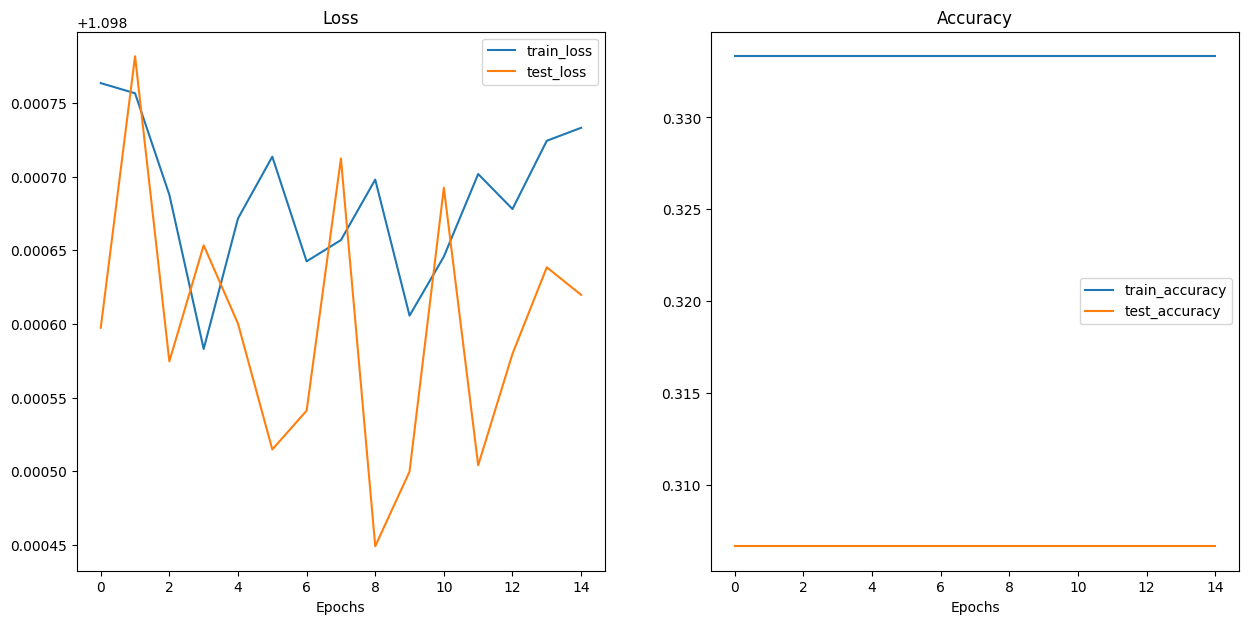

In [ ]:
# Augmented transform results look worse than horizontal flip
plot_loss_curves(model_20_aug_results)

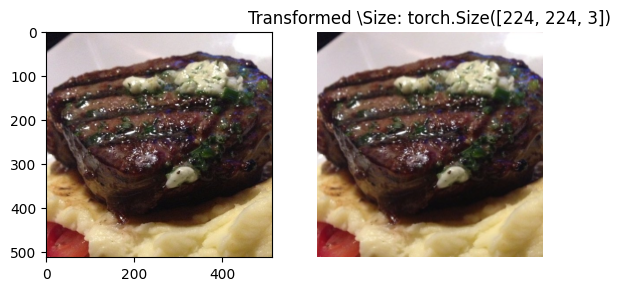

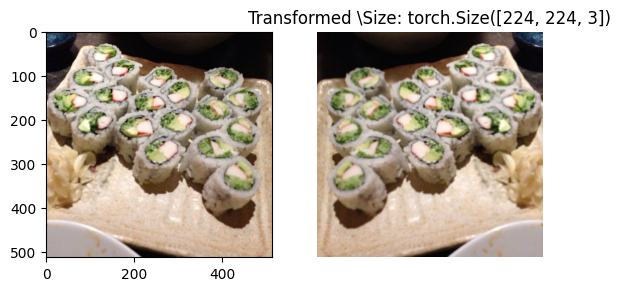

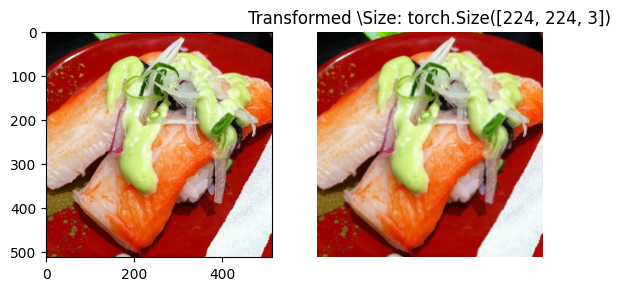

In [ ]:
# See how augmented transformations look
plot_transformed_images(image_paths=image_path_list,
                        transform=data_20_transform,
                        n=3)

In [ ]:
# Compare models
import pandas as pd
model_20_df = pd.DataFrame(model_20_results)
model_20_aug_df = pd.DataFrame(model_20_aug_results)
model_20_df

train_loss  train_acc  test_loss  test_acc
0     1.103828   0.315556   1.093898  0.386667
1     1.096437   0.375556   1.091094  0.393333
2     1.088672   0.406667   1.077380  0.426667
3     1.063712   0.504444   1.019152  0.520000
4     0.988999   0.551111   0.908362  0.586667
5     0.919376   0.591111   0.889957  0.560000
6     0.888785   0.615556   0.893049  0.553333
7     0.877097   0.568889   0.877241  0.600000
8     0.857451   0.615556   0.870573  0.600000
9     0.827340   0.646667   0.887533  0.506667
10    0.810395   0.637778   0.829768  0.626667
11    0.789172   0.633333   0.867408  0.526667
12    0.766859   0.684444   0.879259  0.540000
13    0.754305   0.671111   0.826122  0.653333
14    0.732501   0.655556   0.815155  0.660000

In [ ]:
model_20_aug_df

train_loss  train_acc  test_loss  test_acc
0     1.098763   0.333333   1.098597  0.306667
1     1.098757   0.333333   1.098782  0.306667
2     1.098688   0.333333   1.098575  0.306667
3     1.098583   0.333333   1.098653  0.306667
4     1.098672   0.333333   1.098600  0.306667
5     1.098713   0.333333   1.098515  0.306667
6     1.098642   0.333333   1.098541  0.306667
7     1.098657   0.333333   1.098712  0.306667
8     1.098698   0.333333   1.098449  0.306667
9     1.098606   0.333333   1.098500  0.306667
10    1.098646   0.333333   1.098692  0.306667
11    1.098702   0.333333   1.098504  0.306667
12    1.098678   0.333333   1.098580  0.306667
13    1.098724   0.333333   1.098638  0.306667
14    1.098733   0.333333   1.098620  0.306667

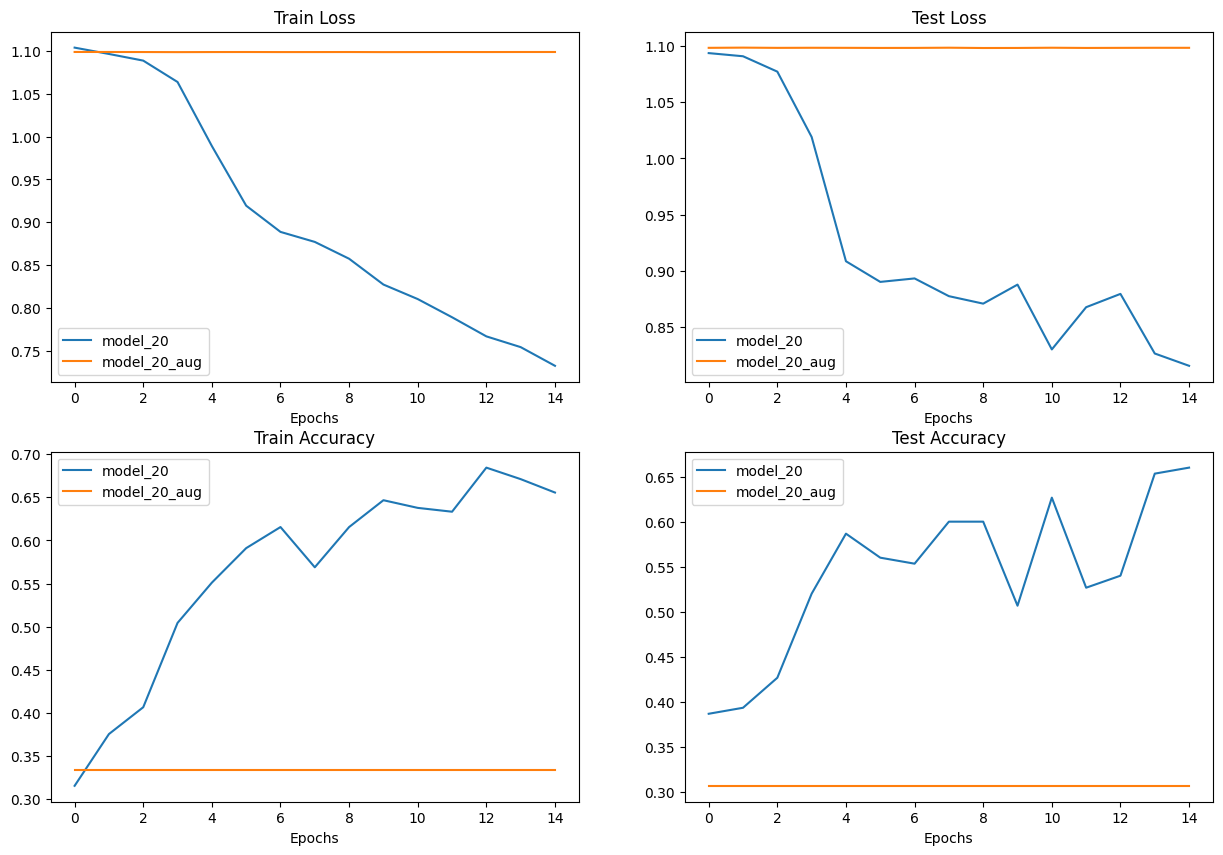

In [ ]:
# Set up a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_20_df))

# Plot train loss
plt.subplot(2,2,1)
plt.plot(epochs, model_20_df["train_loss"], label="model_20")
plt.plot(epochs, model_20_aug_df["train_loss"], label="model_20_aug")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2,2,2)
plt.plot(epochs, model_20_df["test_loss"], label="model_20")
plt.plot(epochs, model_20_aug_df["test_loss"], label="model_20_aug")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2,2,3)
plt.plot(epochs, model_20_df["train_acc"], label="model_20")
plt.plot(epochs, model_20_aug_df["train_acc"], label="model_20_aug")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2,2,4)
plt.plot(epochs, model_20_df["test_acc"], label="model_20")
plt.plot(epochs, model_20_aug_df["test_acc"], label="model_20_aug")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend()

In [ ]:
# 8. Make a prediction on your own custom image
# Download custom image
import requests

# Get multiple custom images
""" to get raw address:  right click jpeg file name in main repository view, select copy link address, paste into browser and enter
    then right click on image, select copy link address = https://github.com/lanehale/pytorch-deep-learning/blob/main/custom_images/cheese-pizza.jpeg?raw=true
    paste into browser and enter to get url format below
"""
urls = [
    "https://raw.githubusercontent.com/lanehale/pytorch-deep-learning/refs/heads/main/custom_images/cheese-pizza.jpeg",
    "https://raw.githubusercontent.com/lanehale/pytorch-deep-learning/refs/heads/main/custom_images/pizza-slice.jpeg",
    "https://raw.githubusercontent.com/lanehale/pytorch-deep-learning/refs/heads/main/custom_images/pizza-slice2.jpeg",
    "https://raw.githubusercontent.com/lanehale/pytorch-deep-learning/refs/heads/main/custom_images/pizza-sliced.jpeg",
    "https://raw.githubusercontent.com/lanehale/pytorch-deep-learning/refs/heads/main/custom_images/pizza-sliced2.jpeg",
    "https://raw.githubusercontent.com/lanehale/pytorch-deep-learning/refs/heads/main/custom_images/pizza-partial-view.jpeg",
    "https://raw.githubusercontent.com/lanehale/pytorch-deep-learning/refs/heads/main/custom_images/pizza-partial-view2.jpeg",
    "https://raw.githubusercontent.com/lanehale/pytorch-deep-learning/refs/heads/main/custom_images/pizza-side-view.jpeg"
]

filenames = [
    "cheese-pizza.jpeg",
    "pizza-slice.jpeg",
    "pizza-slice2.jpeg",
    "pizza-sliced.jpeg",
    "pizza-sliced2.jpeg",
    "pizza-partial-view.jpeg",
    "pizza-partial-view2.jpeg",
    "pizza-side-view.jpeg"
]

if len(urls) != len(filenames):
  raise ValueError("The number of URLs and filenames must be the same.")

# Download the images if they don't already exist
if (data_path / "cheese-pizza.jpeg").is_file():
  print(f"Custom images already exist, skipping download.")
else:
  for i, url in enumerate(urls):
    try:
      response = requests.get(url)
      response.raise_for_status()  # Raise an exception for HTTP errors

      custom_image_path = data_path / filenames[i]

      with open(custom_image_path, "wb") as f:
        f.write(response.content)

      print(f"DownLoading {custom_image_path}...")

    except requests.exceptions.RequestException as e:
      print(f"Error downloading {url}: {e}")
    except Exception as e:
      print(f"An unexpected error occurred: {e}")

DownLoading data/cheese-pizza.jpeg...
DownLoading data/pizza-slice.jpeg...
DownLoading data/pizza-slice2.jpeg...
DownLoading data/pizza-sliced.jpeg...
DownLoading data/pizza-sliced2.jpeg...
DownLoading data/pizza-partial-view.jpeg...
DownLoading data/pizza-partial-view2.jpeg...
DownLoading data/pizza-side-view.jpeg...


In [ ]:
!ls data/

cheese-pizza.jpeg	  pizza-slice2.jpeg   pizza_steak_sushi_20_percent
pizza-partial-view2.jpeg  pizza-sliced2.jpeg  pizza_steak_sushi_20_percent.zip
pizza-partial-view.jpeg   pizza-sliced.jpeg
pizza-side-view.jpeg	  pizza-slice.jpeg


In [ ]:
import torchvision

# Choose a custom image
custom_image_path = data_path / "pizza-slice.jpeg"

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

custom_image_uint8, custom_image_uint8.dtype, custom_image_uint8.shape

(tensor([[[244, 246, 246,  ...,  55,  61,  53],
          [244, 245, 247,  ...,  55,  60,  59],
          [244, 245, 248,  ...,  56,  59,  58],
          ...,
          [253, 254, 252,  ..., 241, 238, 222],
          [242, 250, 248,  ..., 227, 215, 223],
          [247, 247, 246,  ..., 214, 217, 228]],
 
         [[219, 217, 213,  ...,  43,  49,  41],
          [217, 216, 214,  ...,  43,  48,  47],
          [214, 214, 213,  ...,  44,  47,  46],
          ...,
          [238, 241, 239,  ..., 208, 208, 199],
          [233, 241, 241,  ..., 197, 187, 200],
          [238, 238, 237,  ..., 185, 188, 201]],
 
         [[165, 159, 146,  ...,  45,  51,  43],
          [164, 158, 147,  ...,  45,  50,  49],
          [160, 157, 149,  ...,  46,  49,  48],
          ...,
          [231, 233, 231,  ..., 199, 197, 183],
          [226, 234, 233,  ..., 187, 176, 186],
          [233, 233, 232,  ..., 177, 180, 190]]], dtype=torch.uint8),
 torch.uint8,
 torch.Size([3, 225, 225]))

In [ ]:
# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image /= 255

custom_image, custom_image.dtype, custom_image.shape

(tensor([[[0.9569, 0.9647, 0.9647,  ..., 0.2157, 0.2392, 0.2078],
          [0.9569, 0.9608, 0.9686,  ..., 0.2157, 0.2353, 0.2314],
          [0.9569, 0.9608, 0.9725,  ..., 0.2196, 0.2314, 0.2275],
          ...,
          [0.9922, 0.9961, 0.9882,  ..., 0.9451, 0.9333, 0.8706],
          [0.9490, 0.9804, 0.9725,  ..., 0.8902, 0.8431, 0.8745],
          [0.9686, 0.9686, 0.9647,  ..., 0.8392, 0.8510, 0.8941]],
 
         [[0.8588, 0.8510, 0.8353,  ..., 0.1686, 0.1922, 0.1608],
          [0.8510, 0.8471, 0.8392,  ..., 0.1686, 0.1882, 0.1843],
          [0.8392, 0.8392, 0.8353,  ..., 0.1725, 0.1843, 0.1804],
          ...,
          [0.9333, 0.9451, 0.9373,  ..., 0.8157, 0.8157, 0.7804],
          [0.9137, 0.9451, 0.9451,  ..., 0.7725, 0.7333, 0.7843],
          [0.9333, 0.9333, 0.9294,  ..., 0.7255, 0.7373, 0.7882]],
 
         [[0.6471, 0.6235, 0.5725,  ..., 0.1765, 0.2000, 0.1686],
          [0.6431, 0.6196, 0.5765,  ..., 0.1765, 0.1961, 0.1922],
          [0.6275, 0.6157, 0.5843,  ...,

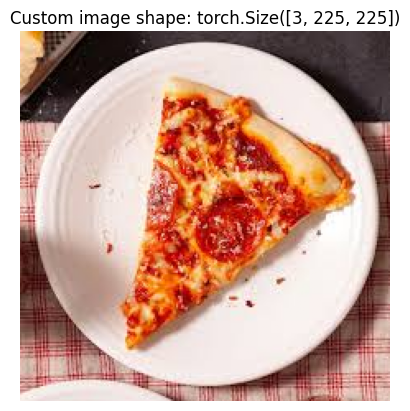

In [ ]:
# Plot the custom image
plt.imshow(custom_image.permute(1, 2, 0))  # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Custom image shape: {custom_image.shape}")
plt.axis(False);

In [ ]:
# Create transform pipeline to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((224, 224))])

# Transform custom image
custom_image_transformed = custom_image_transform(custom_image)

custom_image_transformed.shape

torch.Size([3, 224, 224])

In [ ]:
# Add an extra dimension to image
custom_image_transformed_with_batch_dim = custom_image_transformed.unsqueeze(dim=0)

custom_image_transformed.shape, custom_image_transformed_with_batch_dim.shape

(torch.Size([3, 224, 224]), torch.Size([1, 3, 224, 224]))

In [ ]:
model_20.eval()
with torch.inference_mode():
  # Make a prediction on image with an extra dimension
  custom_image_pred = model_20(custom_image_transformed.unsqueeze(dim=0).to(device))
  custom_image_pred_with_batch = model_20(custom_image_transformed_with_batch_dim.to(device))

custom_image_pred, custom_image_pred_with_batch

(tensor([[-0.5213, -0.1251,  0.5885]], device='cuda:0'),
 tensor([[-0.5213, -0.1251,  0.5885]], device='cuda:0'))

In [ ]:
# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits to prediction probabilities
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)  # using softmax for multi-class classification
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert probabilities to labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[-0.5213, -0.1251,  0.5885]], device='cuda:0')
Prediction probabilities: tensor([[0.1812, 0.2692, 0.5496]], device='cuda:0')
Prediction label: tensor([2], device='cuda:0')


In [ ]:
# Find the predicted label
custom_image_pred_class = class_names[custom_image_pred_label.cpu().item()]  # pred label has to be on cpu
custom_image_pred_class

'sushi'

In [ ]:
# Predicted label using custom pizza slice image above is wrong, got sushi
# custom_image_pred_with_batch has same logits so it's no different
custom_image_pred2_probs = torch.softmax(custom_image_pred_with_batch, dim=1)
custom_image_pred2_label = torch.argmax(custom_image_pred2_probs, dim=1)
custom_image_pred2_class = class_names[custom_image_pred2_label.cpu().item()]
custom_image_pred2_class, custom_image_pred2_label, custom_image_pred2_probs

('sushi',
 tensor([2], device='cuda:0'),
 tensor([[0.1812, 0.2692, 0.5496]], device='cuda:0'))

In [ ]:
# A function that makes a prediction on a target image and plots the image with its prediction
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform = None,
                        device: torch.device = device):
  # 1. Load in an image and convert tensor values to float32
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

  # 2. Divide the image pixel values by 255 to get them between 0 and 1
  target_image /= 255

  # 3. Transform if necessary
  if transform:
    target_image = transform(target_image)

  # 4. Make sure model is on target device
  model.to(device)

  # 5. Turn on model evaluation and inference modes
  model.eval()
  with torch.inference_mode():
    # Add an extra dimension to image
    target_image = target_image.unsqueeze(dim=0)
    # Make a prediction on image with an extra dimension and send it to the target device
    target_image_pred = model(target_image.to(device))

  # 6. Convert logits to probabilities
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  # 7. Convert probs to label
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # 8. Plot the image alongside the prediction and prediction probability
  plt.imshow(target_image.squeeze().permute(1, 2, 0))  # make sure it's right size for matplotlib
  if class_names:
    title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  else:
    title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  plt.title(title)
  plt.axis(False);

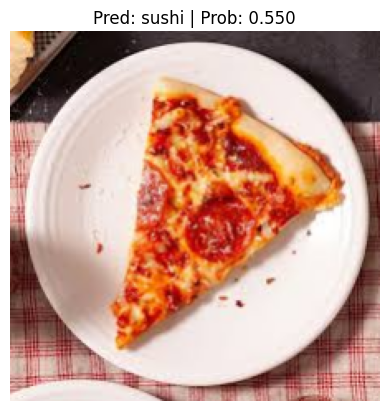

In [ ]:
# Prediction on our custom image
custom_image_path = data_path / "pizza-slice.jpeg"

pred_and_plot_image(model=model_20,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

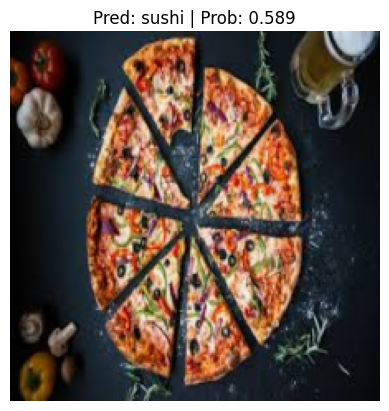

In [ ]:
# Choose another custom image
custom_image_path = data_path / "pizza-sliced.jpeg"

pred_and_plot_image(model=model_20,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

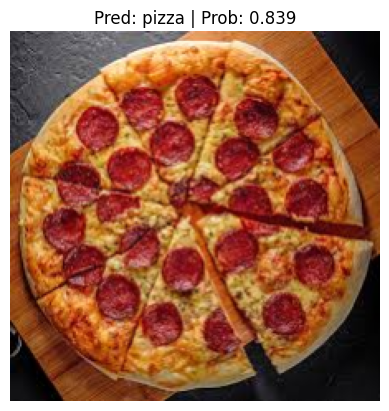

In [ ]:
# Choose another custom image
custom_image_path = data_path / "pizza-sliced2.jpeg"

pred_and_plot_image(model=model_20,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

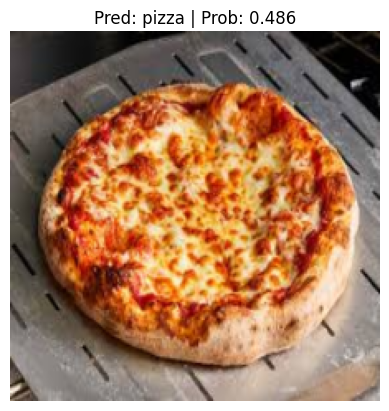

In [ ]:
# Choose another custom image
custom_image_path = data_path / "cheese-pizza.jpeg"

pred_and_plot_image(model=model_20,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

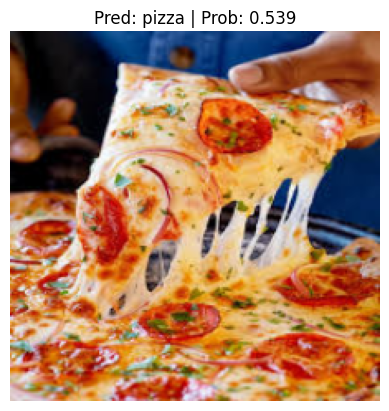

In [ ]:
# Choose another custom image
custom_image_path = data_path / "pizza-slice2.jpeg"

pred_and_plot_image(model=model_20,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

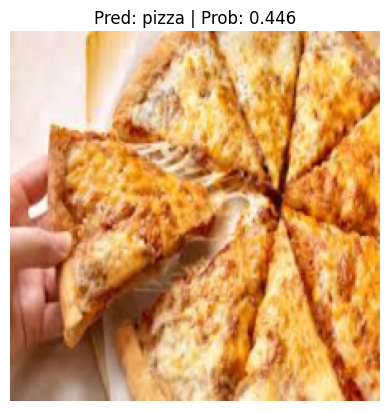

In [ ]:
# Choose another custom image
custom_image_path = data_path / "pizza-partial-view.jpeg"

pred_and_plot_image(model=model_20,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

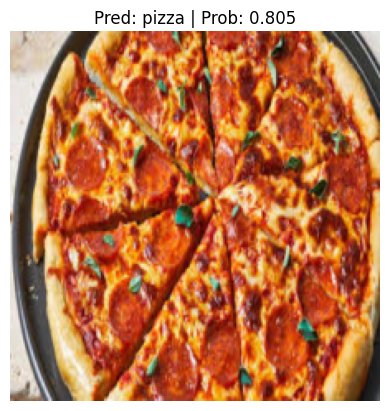

In [ ]:
# Choose another custom image
custom_image_path = data_path / "pizza-partial-view2.jpeg"

pred_and_plot_image(model=model_20,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

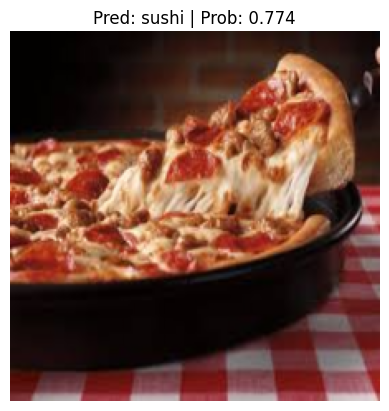

In [ ]:
# Choose another custom image
custom_image_path = data_path / "pizza-side-view.jpeg"

pred_and_plot_image(model=model_20,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)